# Análisis Financiero con Random Forest

In [1]:
# Carga Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import joblib

In [2]:
# Cargar el dataset
file_path = 'Fraud.csv'
df = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Cambio de nombre de las columnas
column_mapping = {
    'step': 'paso',
    'type': 'tipo_transaccion',
    'amount': 'monto',
    'nameOrig': 'nombre_cliente_origen',
    'oldbalanceOrg': 'saldo_antes_origen',
    'newbalanceOrig': 'saldo_despues_origen',
    'nameDest': 'nombre_cliente_destino',
    'oldbalanceDest': 'saldo_antes_destino',
    'newbalanceDest': 'saldo_despues_destino',
    'isFraud': 'es_fraude',
    'isFlaggedFraud': 'es_marcado_fraude'
}

# Aplicar los cambios
df.rename(columns=column_mapping, inplace=True)

# Mostrar datos
df.head()

,paso,tipo_transaccion,monto,nombre_cliente_origen,saldo_antes_origen,saldo_despues_origen,nombre_cliente_destino,saldo_antes_destino,saldo_despues_destino,es_fraude,es_marcado_fraude
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Revisión de nulos
df.isnull().sum()

paso                      0
tipo_transaccion          0
monto                     0
nombre_cliente_origen     0
saldo_antes_origen        0
saldo_despues_origen      0
nombre_cliente_destino    0
saldo_antes_destino       0
saldo_despues_destino     0
es_fraude                 0
es_marcado_fraude         0
dtype: int64

In [5]:
#Revisión de duplicados
df.duplicated().sum()

0

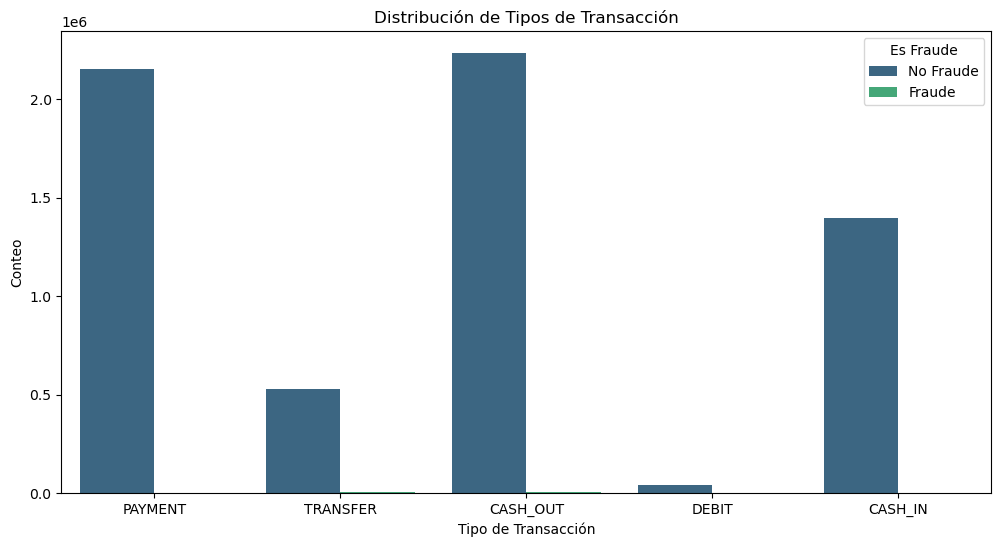

In [6]:
# Distribución de tipos de transacción
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='tipo_transaccion', hue='es_fraude', palette='viridis')
plt.title('Distribución de Tipos de Transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Conteo')
plt.legend(title='Es Fraude', labels=['No Fraude', 'Fraude'])
plt.show()

In [7]:
# Transformar la variable categórica 'tipo_transaccion' usando one-hot encoding
df = pd.get_dummies(df, columns=['tipo_transaccion'], drop_first=True)

In [8]:
# Seleccionar variables relevantes para el modelo
variables_relevantes = [
    'monto', 'saldo_antes_origen', 'saldo_despues_origen', 'saldo_antes_destino',
    'saldo_despues_destino', 'tipo_transaccion_CASH_OUT', 'tipo_transaccion_DEBIT', 'tipo_transaccion_PAYMENT',
    'tipo_transaccion_TRANSFER'
]

In [9]:
# Crear el nuevo DataFrame con las variables seleccionadas
data_model = df[variables_relevantes + ['es_fraude']]

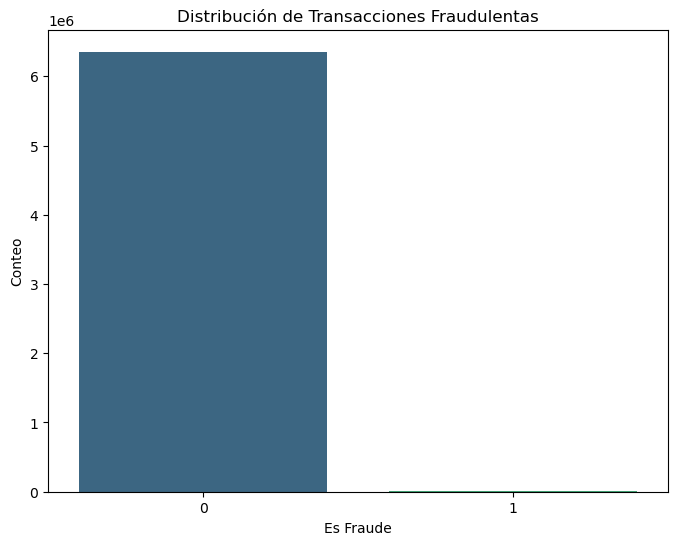

In [10]:
# Distribución de la variable 'es_fraude'
plt.figure(figsize=(8, 6))
sns.countplot(x='es_fraude', data=data_model, palette='viridis')
plt.title('Distribución de Transacciones Fraudulentas')
plt.xlabel('Es Fraude')
plt.ylabel('Conteo')
plt.show()

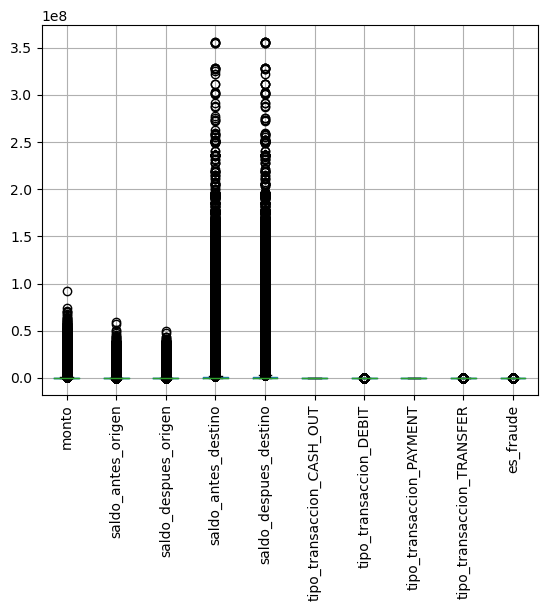

In [11]:
# Importamos la librería matplotlib
import matplotlib.pyplot as plt

# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots()

# Hacemos un gráfico de caja para cada columna
data_model.boxplot(ax=ax)

# Rotamos los nombres de las columnas para que sean legibles
plt.xticks(rotation=90)

# Mostramos el gráfico
plt.show()

#### Graficamos la correlación entre variables

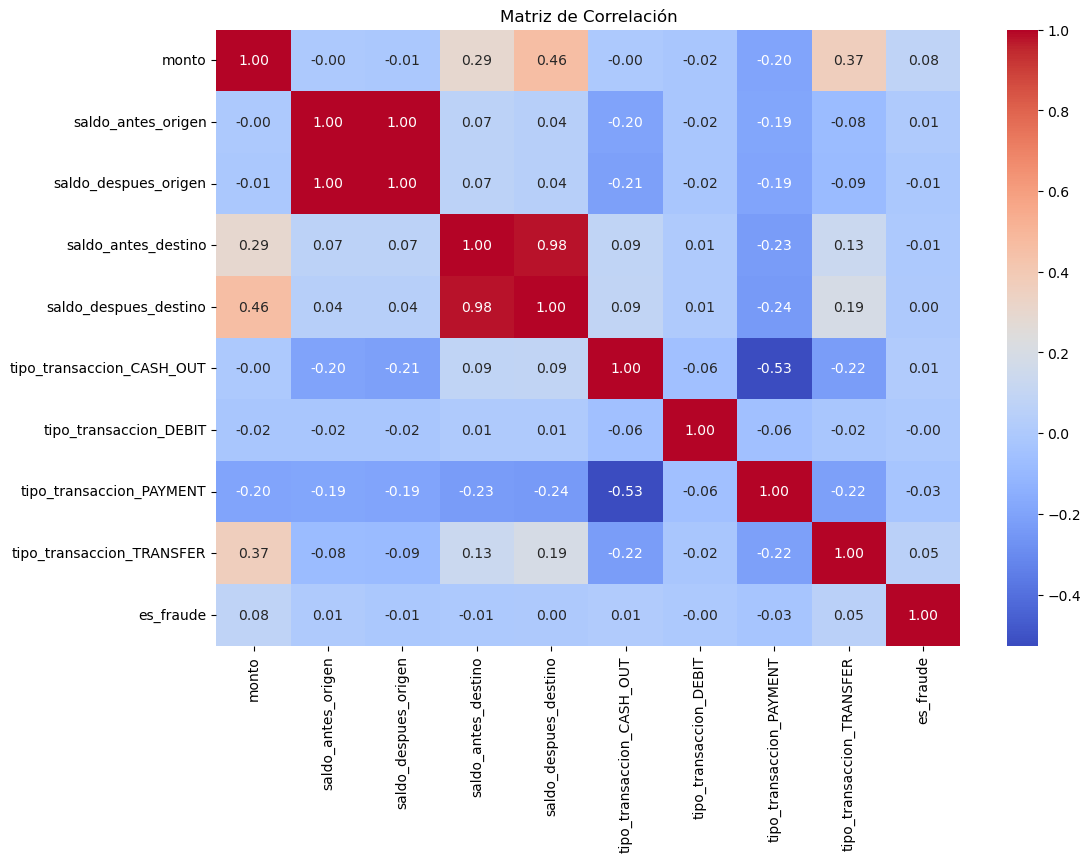

In [12]:
# Matriz de correlación
matriz_correlacion = data_model.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm')
#sns.heatmap(matriz_correlacion, annot = True, cmap="Accent")
plt.title("Matriz de Correlación")
plt.show()


#### Separamos las variables predictoras `X`, de las variables objetivo `y`

In [13]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data_model.drop('es_fraude', axis=1)
y = data_model['es_fraude']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#### Usamos el modelo para hacer predicciones

In [16]:
# Seleccionamos una persona de la base de datos de prueba para realizar una predicción
persona_de_prueba = X_test.iloc[[63000]]
persona_de_prueba

,monto,saldo_antes_origen,saldo_despues_origen,saldo_antes_destino,saldo_despues_destino,tipo_transaccion_CASH_OUT,tipo_transaccion_DEBIT,tipo_transaccion_PAYMENT,tipo_transaccion_TRANSFER
5969429,13401.92,0.0,0.0,0.0,0.0,False,False,True,False


In [19]:
# Datos en formato de lista
datos = [[181.00, 181.0, 0.00, 21182.0, 0.0, 1, 0, 0,0]]

# Definir los nombres de las columnas
columnas = ["monto", "saldo_antes_origen", "saldo_despues_origen", "saldo_antes_destino", "saldo_despues_destino", "tipo_transaccion_CASH_OUT","tipo_transaccion_DEBIT","tipo_transaccion_PAYMENT","tipo_transaccion_TRANSFER"]

# Convertir la lista a un DataFrame
df_tran_prueba = pd.DataFrame(datos, columns=columnas)

# Mostrar el DataFrame resultante
df_tran_prueba

,monto,saldo_antes_origen,saldo_despues_origen,saldo_antes_destino,saldo_despues_destino,tipo_transaccion_CASH_OUT,tipo_transaccion_DEBIT,tipo_transaccion_PAYMENT,tipo_transaccion_TRANSFER
0,181.0,181.0,0.0,21182.0,0.0,1,0,0,0


In [20]:
# Hacemos una predicción con el modelo entrenado
prediccion = rf_model.predict(df_tran_prueba)
prediccion

array([1], dtype=int64)

In [21]:
# Comprobamos si la persona tiene diabetes o no según la predicción
if prediccion >= 0.5:
    print('Según la predicción de Random Forest: La transacción es fraudulenta')
else:
    print('Según la predicción de Random Forest: La transacción no es fraudulenta')

# Comprobamos si la persona tiene diabetes o no según la base de datos
if y_test.iloc[63000] == 1:
    print('Según la base de datos de prueba: La transacción es fraudulenta')
else:
    print('Según la base de datos de prueba: La transacción no es fraudulenta')

Según la predicción de Random Forest: La transacción es fraudulenta
Según la base de datos de prueba: La transacción no es fraudulenta


#### Guardar el modelo

In [22]:
# Guardar el modelo entrenado
joblib.dump(rf_model, 'modelo_fraude_financiero.joblib')

['modelo_fraude_financiero.joblib']